In [241]:
# read in images.txt from dir

import os
import sys
import re
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon
from shapely.ops import unary_union

# Read in lat/lon and image filenames
path = os.path.join(  '../Data', 'ProcessedData', 'SFStreetView', 'Res_640', 'PittsburghDowntown_2024-03-20', 'images.txt' )
df = pd.read_csv(path, sep=' ', header=None)

# rename columns 
cols = ['segment_id', 'filename', 'image_panoid', 'date', 'query_counter', 'lat', 'lon', 'end']
df.columns = cols
df.drop('end', axis=1, inplace=True)

# convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Convert to geopandas with lat/lon as point coordinates geometry
pics_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

pics_gdf['years_since_today'] = (pd.Timestamp('2024-03-20') - pics_gdf['date']) 

# transform days to roughly equal years that have passed
pics_gdf['years_since_today'] = round( pics_gdf['years_since_today'].dt.days/365 , 2)

# Create subset of not saved
not_saved = pics_gdf[pics_gdf['filename'] == 'NotSaved']

# filter to only include filename != NotSaved
pics_gdf = pics_gdf[pics_gdf['filename'] != 'NotSaved']

# Extract last 6 characters before ".png" as img_id
pics_gdf['img_id'] = pics_gdf['filename'].apply(lambda x: x[-10:-4])

print(f"Number of images: {len(pics_gdf)}")
print(f"Number of images not saved: {len(not_saved)}")

print(type(pics_gdf))
pics_gdf


Number of images: 9043
Number of images not saved: 18828
<class 'geopandas.geodataframe.GeoDataFrame'>


,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,img_id
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (-80.00754 40.44730),1.72,h0_000
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (-80.00754 40.44730),1.72,h1_001
4,104197837-271197326,img_104197837-271197326_h0_002.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,4.0,40.447208,-80.007510,POINT (-80.00751 40.44721),1.72,h0_002
5,104197837-271197326,img_104197837-271197326_h1_003.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,5.0,40.447208,-80.007510,POINT (-80.00751 40.44721),1.72,h1_003
10,104197837-271197326,img_104197837-271197326_h0_004.png,RxyMGiyoWym7PsB6LXBG6A,2022-07-01,10.0,40.447093,-80.007474,POINT (-80.00747 40.44709),1.72,h0_004
...,...,...,...,...,...,...,...,...,...,...
27848,105116527-10970185374,img_105116527-10970185374_h1_001.png,zetqk7qEuvpT82BgGoVgRw,2023-05-01,9.0,40.437957,-80.004160,POINT (-80.00416 40.43796),0.89,h1_001
27851,105116527-10970185374,img_105116527-10970185374_h0_002.png,86NWZiQxDKwRr4gDGKld8A,2023-10-01,12.0,40.437913,-80.004374,POINT (-80.00437 40.43791),0.47,h0_002
27852,105116527-10970185374,img_105116527-10970185374_h1_003.png,86NWZiQxDKwRr4gDGKld8A,2023-10-01,13.0,40.437913,-80.004374,POINT (-80.00437 40.43791),0.47,h1_003
27867,105116527-10970185374,img_105116527-10970185374_h0_004.png,WxPeiIxfXMlduvcaRHFCtQ,2023-10-01,28.0,40.437737,-80.003904,POINT (-80.00390 40.43774),0.47,h0_004


# Merge in detections

In [242]:
# load detected objects df
detections = pd.read_csv('../Data/Output/YOLO_output/detections.csv')

# merge on segment_id and img_id
pics_gdf = pd.merge(detections, pics_gdf, on=['segment_id' , 'img_id'], how='outer')

pics_gdf.head()

,segment_id,img_id,object_id,confidence,bbox_size,x1,y1,x2,y2,class,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today
0,104197837-271197326,h0_000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (-80.00754 40.44730),1.72
1,104197837-271197326,h0_002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,img_104197837-271197326_h0_002.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,4.0,40.447208,-80.007510,POINT (-80.00751 40.44721),1.72
2,104197837-271197326,h0_004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,img_104197837-271197326_h0_004.png,RxyMGiyoWym7PsB6LXBG6A,2022-07-01,10.0,40.447093,-80.007474,POINT (-80.00747 40.44709),1.72
3,104197837-271197326,h0_006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,img_104197837-271197326_h0_006.png,UGj7aBRoVd0Bm66NvxGjqw,2022-07-01,14.0,40.447012,-80.007449,POINT (-80.00745 40.44701),1.72
4,104197837-271197326,h0_008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,img_104197837-271197326_h0_008.png,AQZQmcEju6SveGJxIojEbw,2022-07-01,18.0,40.446924,-80.007422,POINT (-80.00742 40.44692),1.72


In [243]:
# read in segments json file to get segment_id to segment_name mapping
path = os.path.join(  '../Data', 'ProcessedData', 'SFStreetView', 'segment_dictionary_PittsburghDowntown.json' )
segments = pd.read_json(path, orient='index')

# segment_id is a string formatted as a list. Modify it to remove brackets, comma and cocatentate with hypen
segments['segment_id'] = segments['segment_id'].apply(lambda x: x.replace('[','').replace(']', '').replace(', ','-'))

# Merge name, length and bearing to pics_gdf
pics_gdf = pics_gdf.merge(segments[['segment_id', 'name', 'length', 'bearing']], on='segment_id')

# Convert back to geodf
pics_gdf = gpd.GeoDataFrame(pics_gdf, geometry=gpd.points_from_xy(pics_gdf.lon, pics_gdf.lat))

type(pics_gdf)

geopandas.geodataframe.GeoDataFrame

In [244]:
import matplotlib.pyplot as plt
import json

# Define the directories containing the shapefiles

neighbord_gdf = gpd.read_file('pittsburgh_gis_data/Neighborhoods_/Neighborhoods_.shp')
parks_gdf = gpd.read_file('pittsburgh_gis_data/PGHWebParks/PGHWebParks.shp')
roads_gdf = gpd.read_file('pittsburgh_gis_data/tl_2020_42003_roads/tl_2020_42003_roads.shp')
water_gdf = gpd.read_file('pittsburgh_gis_data/majrivrs/majrivrs.shp')

# read in json of downtown 
with open('./pittsburgh_gis_data/downtown_polygon.json', 'r') as file:
    downtown_polygon = json.load(file)
downtown_gdf = gpd.GeoDataFrame.from_features(downtown_polygon['features'])


# read in downtown_surrounds_polygon.json and clip 4 gdfs to area
with open('./pittsburgh_gis_data/downtown_surroundings_polygon.json', 'r') as file:
    downtown_surrounds_polygon = json.load(file)

# Clip neighborhood, parks, roads, and water to downtown_surrounds_polygon
downtown_surrounds_gdf = gpd.GeoDataFrame.from_features(downtown_surrounds_polygon['features'])
neighbord_gdf = gpd.clip(neighbord_gdf, downtown_surrounds_gdf)
parks_gdf = gpd.clip(parks_gdf, downtown_surrounds_gdf)
roads_gdf = gpd.clip(roads_gdf, downtown_surrounds_gdf)
water_gdf = gpd.clip(water_gdf, downtown_surrounds_gdf)

/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_28376/3386658601.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  neighbord_gdf = gpd.clip(neighbord_gdf, downtown_surrounds_gdf)
/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_28376/3386658601.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  parks_gdf = gpd.clip(parks_gdf, downtown_surrounds_gdf)
/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_28376/3386658601.py:25: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CR

Min Size: 131.965


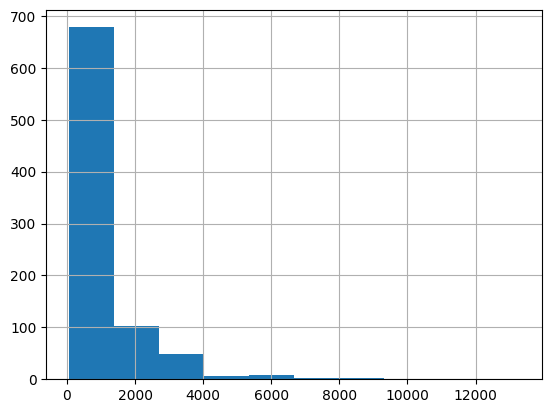

In [245]:
# Filter pics_gdf to only include fire_hydrant in class and plot occurrences

fire_hydrants = pics_gdf[pics_gdf['class'] == 'fire_hydrant']

# For fire_hydrants, get distribution of bbox_size column by plotting hist
fire_hydrants['bbox_size'].hist()

# Filter to only include bbox_size above 10th percentile and confidence > .7
min_size = fire_hydrants['bbox_size'].quantile(0.05) 
fire_hydrants = fire_hydrants[(fire_hydrants['bbox_size'] > min_size) & (fire_hydrants['confidence'] > 0.3)]
print(f"Min Size: {min_size}")

In [246]:
# For any row that is within 10m of another row, drop the row with the lower confidence
fire_hydrants = fire_hydrants.sort_values('confidence', ascending=False)
fire_hydrants['geometry'] = fire_hydrants['geometry'].buffer(0.00015)

# Find overlapping polygons using spatial join
overlaps = gpd.sjoin(fire_hydrants, fire_hydrants, how='inner', op='intersects')
overlaps = overlaps[overlaps.index != overlaps.index_right]  # Remove self-overlaps

overlaps['index_left'] = overlaps.index
overlaps

/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/SCHOOL/Year2_Spring/IndepStudyProject/yoloso-urbanchange-6f00b5e/myenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,segment_id_left,img_id_left,object_id_left,confidence_left,bbox_size_left,x1_left,y1_left,x2_left,y2_left,class_left,...,image_panoid_right,date_right,query_counter_right,lat_right,lon_right,years_since_today_right,name_right,length_right,bearing_right,index_left
25659,105175777-105963824,h1_007,0.0,0.9456,1719.61,328.2971,429.3407,360.8099,482.2310,fire_hydrant,...,JCHjUFkNJ2BZENkU3Xg85w,2023-05-01,14.0,40.446896,-79.989130,0.89,Liberty Avenue,281.983,231.0,25659
25659,105175777-105963824,h1_007,0.0,0.9456,1719.61,328.2971,429.3407,360.8099,482.2310,fire_hydrant,...,j3UqCg0d3QgCpS6rOjDFDg,2023-05-01,33.0,40.446841,-79.989228,0.89,14th Street,79.462,140.5,25659
25659,105175777-105963824,h1_007,0.0,0.9456,1719.61,328.2971,429.3407,360.8099,482.2310,fire_hydrant,...,j3UqCg0d3QgCpS6rOjDFDg,2023-05-01,9.0,40.446841,-79.989228,0.89,Liberty Avenue,253.658,51.8,25659
18714,104945576-104945585,h0_000,0.0,0.9333,2800.18,90.9668,437.4781,126.7683,515.6918,fire_hydrant,...,wVImETcrAJmw_866RXzBqw,2023-05-01,8.0,40.437896,-79.999059,0.89,Cherry Way,63.590,208.3,18714
18714,104945576-104945585,h0_000,0.0,0.9333,2800.18,90.9668,437.4781,126.7683,515.6918,fire_hydrant,...,m1mYS6JG77V9PBo0MlqNCw,2023-05-01,5.0,40.437950,-79.999205,0.89,Cherry Way,54.741,204.3,18714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5596,104573441-104573452,h1_003,7.0,0.3030,238.24,46.7980,365.5503,56.8843,389.1704,fire_hydrant,...,bbG6FK3OXzgeWcRtkSUjoQ,2023-05-01,5.0,40.438832,-79.994757,0.89,Sixth Avenue,79.014,165.6,5596
5596,104573441-104573452,h1_003,7.0,0.3030,238.24,46.7980,365.5503,56.8843,389.1704,fire_hydrant,...,D_oBrBZkUjKQSLwc_9iL-g,2023-05-01,2.0,40.438944,-79.994678,0.89,Fifth Avenue,77.654,272.0,5596
5596,104573441-104573452,h1_003,7.0,0.3030,238.24,46.7980,365.5503,56.8843,389.1704,fire_hydrant,...,KwMUUfmR57cEl_uM5fCx5w,2023-05-01,0.0,40.438945,-79.994738,0.89,Fifth Avenue,77.654,272.0,5596
5596,104573441-104573452,h1_003,7.0,0.3030,238.24,46.7980,365.5503,56.8843,389.1704,fire_hydrant,...,KwMUUfmR57cEl_uM5fCx5w,2023-05-01,78.0,40.438945,-79.994738,0.89,Fifth Avenue,187.835,272.7,5596


In [247]:

# Create a graph of overlapping polygons
G = nx.Graph()
for _, row in overlaps.iterrows():
    G.add_edge(row['index_left'], row['index_right'])

# Find connected components (groups of overlapping polygons)
groups = list(nx.connected_components(G))
groups
  

[{25509, 25655, 25659, 25738},
 {9472, 9490, 18714, 18742},
 {9897, 9902, 9943, 20590, 20654, 20667, 20749, 20831, 39113, 39198, 39296},
 {31974, 32008, 32058, 32059},
 {1382, 1487, 1553, 1657, 1844, 39389, 39498, 39499, 42513, 42615, 43586},
 {22793, 22833, 22928, 22930},
 {6512,
  6603,
  6606,
  6698,
  6699,
  6700,
  6701,
  6702,
  6703,
  6704,
  6705,
  6706,
  6707,
  6708,
  8200,
  8287,
  41205,
  41318},
 {11359, 11458, 11475, 11506},
 {13388,
  13985,
  14034,
  14056,
  14310,
  14412,
  15857,
  16129,
  16201,
  16211,
  16308,
  21129,
  21158,
  21217,
  21276,
  23552,
  23556},
 {8932, 20019, 20030, 20093, 20107, 20134, 20140, 20223, 20241},
 {7264, 8111},
 {27730, 27897},
 {13420, 13526, 13603, 13624, 13800},
 {11829, 11857},
 {19489, 19506, 19522, 20743, 20764, 20893, 23271, 23332, 23459, 39037, 39182},
 {1041, 1083, 1160, 1266, 1362, 1363, 1374, 5002, 5339},
 {18808, 31733, 32024, 32027, 32032},
 {14593, 14609, 33633},
 {14261, 14345},
 {10533, 10580, 10619, 307

In [248]:
# Assign group IDs to the original GeoDataFrame
group_dict = {idx: group_id for group_id, group in enumerate(groups) for idx in group}
fire_hydrants['group'] = fire_hydrants.index.map(group_dict)

# In each group, keep the row with the highest value for "bbox_size"
fire_hydrants_dissolved = fire_hydrants.groupby('group').apply(lambda x: x.loc[x['bbox_size'].idxmax()])


# Use unary_union to merge the geometries within each group
fire_hydrants_dissolved['geometry'] = fire_hydrants_dissolved.geometry.apply(lambda x: unary_union(x))

# Set geometry to centroid
fire_hydrants_dissolved['geometry'] = fire_hydrants_dissolved.geometry.centroid

fire_hydrants_dissolved.head()

/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_28376/3606341627.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fire_hydrants_dissolved = fire_hydrants.groupby('group').apply(lambda x: x.loc[x['bbox_size'].idxmax()])


,segment_id,img_id,object_id,confidence,bbox_size,x1,y1,x2,y2,class,...,date,query_counter,lat,lon,geometry,years_since_today,name,length,bearing,group
group,,,,,,,,,,,,,,,,,,,,,
0.0,105175777-5175252868,h0_006,0.0,0.9278,1731.88,340.4116,428.4169,372.4845,482.4153,fire_hydrant,...,2023-05-01,14.0,40.446896,-79.989130,POINT (-79.98913 40.44690),0.89,Liberty Avenue,281.983,231.0,0.0
1.0,104650329-104945585,h0_002,0.0,0.9139,3553.36,45.5627,446.2884,88.2765,529.4785,fire_hydrant,...,2023-05-01,8.0,40.437896,-79.999059,POINT (-79.99906 40.43790),0.89,Cherry Way,63.590,208.3,1.0
2.0,104650336-105012740,h1_007,8.0,0.6079,3572.92,197.8513,563.0518,244.4508,639.7246,fire_hydrant,...,2023-05-01,13.0,40.438664,-79.997367,POINT (-79.99737 40.43866),0.89,Grant Street,81.953,27.2,2.0
3.0,106343507-689935158,h0_012,2.0,0.4325,3580.52,252.7519,376.4605,294.2195,462.8054,fire_hydrant,...,2023-05-01,26.0,40.438127,-79.999942,POINT (-79.99994 40.43813),0.89,Smithfield Street,67.236,26.6,3.0
4.0,104482657-4599846721,h0_000,0.0,0.9207,4203.77,37.6360,451.9064,85.7569,539.2651,fire_hydrant,...,2023-08-01,0.0,40.436882,-79.998419,POINT (-79.99842 40.43688),0.64,Boulevard of the Allies,36.323,118.7,4.0


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_28376/1348757385.py:5: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_gdf.plot(ax=ax, color='blue', alpha = .7)


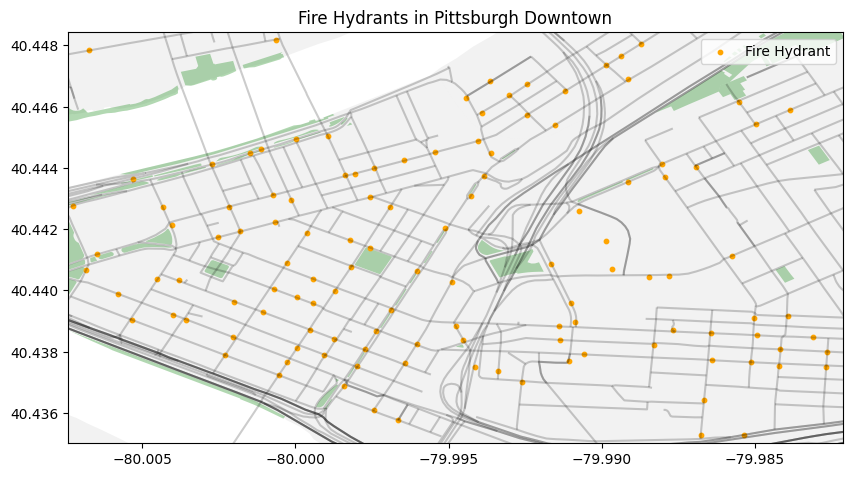

In [249]:


fig, ax = plt.subplots(figsize=(10,10))
neighbord_gdf.plot(ax=ax, color='gray', alpha = .1)
parks_gdf.plot(ax=ax, color='green', alpha = .3)
roads_gdf.plot(ax=ax, color='black', alpha = .2)
water_gdf.plot(ax=ax, color='blue', alpha = .7)

fire_hydrants_dissolved.plot(ax=ax, color='orange', markersize=10, label='Fire Hydrant')
plt.legend()
plt.title('Fire Hydrants in Pittsburgh Downtown')

# Zoom to extent that fire hydrants are visible, setting axis to min/max lat/lon of fire hydrants
minx, miny, maxx, maxy = fire_hydrants.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)


plt.show()


In [250]:
# Show value counts of class column where count > 5
pics_gdf['class'].value_counts()[pics_gdf['class'].value_counts() > 20]

class
car              30352
person            6286
traffic_light     4433
truck             1761
potted_plant      1656
fire_hydrant       851
bench              633
bus                431
stop_sign          391
bicycle            318
clock              317
bird               226
train              181
umbrella           155
chair              148
backpack           148
motorcycle         120
handbag            116
parking_meter       85
dining_table        81
boat                62
tennis_racket       58
skateboard          57
airplane            40
suitcase            40
kite                35
refrigerator        27
bottle              22
Name: count, dtype: int64